# GANs For Art

In [ ]:
Reference: https://blog.jovian.ai/generating-art-with-gans-352ceef3d51f

## Importing the modules

In [2]:
import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets.folder import default_loader
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Preparing the data

In [9]:
!pwd
!ls

/c/Users/ianhu/OneDrive/Projects/GANBatik
ARTGAN.ipynb
README.md
datasets
project-GANs_for_Art.ipynb


In [4]:
artists = pd.read_csv("datasets/artists.csv")

for i in artists['name']:
    print(i,end=" | ")

Amedeo Modigliani | Vasiliy Kandinskiy | Diego Rivera | Claude Monet | Rene Magritte | Salvador Dali | Edouard Manet | Andrei Rublev | Vincent van Gogh | Gustav Klimt | Hieronymus Bosch | Kazimir Malevich | Mikhail Vrubel | Pablo Picasso | Peter Paul Rubens | Pierre-Auguste Renoir | Francisco Goya | Frida Kahlo | El Greco | Albrecht Dürer | Alfred Sisley | Pieter Bruegel | Marc Chagall | Giotto di Bondone | Sandro Botticelli | Caravaggio | Leonardo da Vinci | Diego Velazquez | Henri Matisse | Jan van Eyck | Edgar Degas | Rembrandt | Titian | Henri de Toulouse-Lautrec | Gustave Courbet | Camille Pissarro | William Turner | Edvard Munch | Paul Cezanne | Eugene Delacroix | Henri Rousseau | Georges Seurat | Paul Klee | Piet Mondrian | Joan Miro | Andy Warhol | Paul Gauguin | Raphael | Michelangelo | Jackson Pollock | 

In [5]:
batch_size = 128
image_size = (64,64)
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [6]:
transform_ds = transforms.Compose([transforms.Resize(image_size),
#                                    transforms.RandomCrop(32, padding=2),
#                                    transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*stats)
                                   ])

train_ds = torchvision.datasets.ImageFolder(root="datasets/resized",
                                     transform=transform_ds)

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
print(len(train_ds))

8683


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])


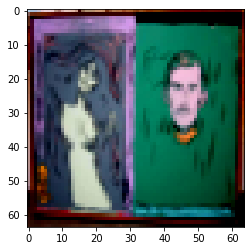

In [12]:
images,_ = train_ds[1337]
print(images.size())
plt.imshow(images.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


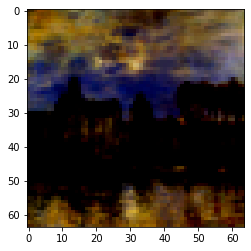

In [13]:
images,_ = train_ds[666]
plt.imshow(images.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


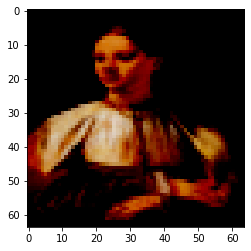

In [14]:
images,_ = train_ds[1990]
plt.imshow(images.permute(1,2,0))

In [15]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [16]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

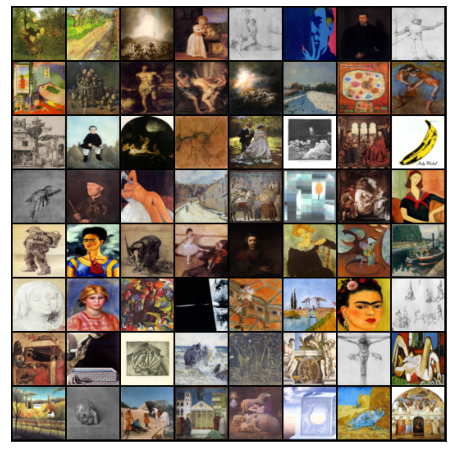

In [17]:
show_batch(train_dl)

In [53]:
torch.cuda.is_available()

True

In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [19]:
device = get_default_device()
device

device(type='cuda')

In [20]:
train_dl = DeviceDataLoader(train_dl, device)

In [21]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [22]:
discriminator = to_device(discriminator, device)

In [23]:
latent_size = 150

In [24]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

## Defining the model

torch.Size([128, 3, 64, 64])


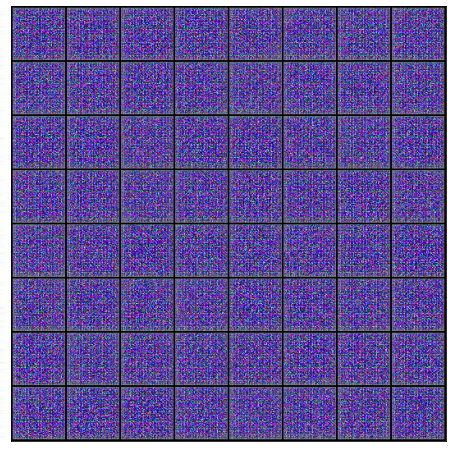

In [25]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [26]:
generator = to_device(generator, device)

In [27]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [28]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [29]:
from torchvision.utils import save_image

In [30]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [31]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [32]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


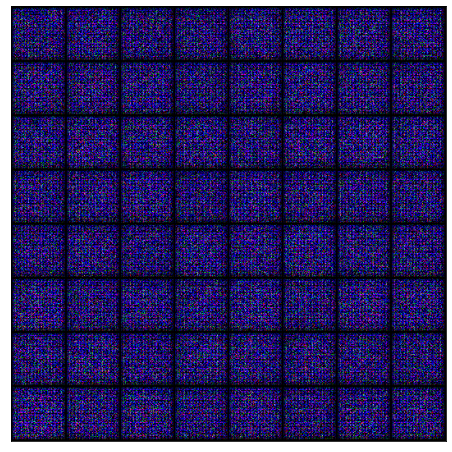

In [33]:
save_samples(0, fixed_latent)

In [34]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [35]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [41]:
#!pip install jovian --upgrade --quiet

In [48]:
#import jovian

In [99]:
#jovian.commit(project="project-GANs for Art", environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/blue-marker/project-GANs for Art


<IPython.core.display.Javascript object>

In [53]:
#jovian.reset()
#jovian.log_hyperparams(lr=lr, epochs=epochs)

[jovian] Hyperparams logged.


In [36]:
lr = 0.001
epochs = 150

In [37]:
history = fit(epochs,lr)

  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [1/150], loss_g: 3.1947, loss_d: 0.2838, real_score: 0.8658, fake_score: 0.1159
Saving generated-images-0001.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [2/150], loss_g: 1.0065, loss_d: 0.9232, real_score: 0.6175, fake_score: 0.2832
Saving generated-images-0002.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [3/150], loss_g: 0.6031, loss_d: 1.1059, real_score: 0.4692, fake_score: 0.2050
Saving generated-images-0003.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [4/150], loss_g: 1.7200, loss_d: 1.1807, real_score: 0.3933, fake_score: 0.0721
Saving generated-images-0004.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [5/150], loss_g: 3.4418, loss_d: 0.4495, real_score: 0.7833, fake_score: 0.1544
Saving generated-images-0005.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [6/150], loss_g: 2.7595, loss_d: 0.4827, real_score: 0.7474, fake_score: 0.1488
Saving generated-images-0006.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [7/150], loss_g: 1.8653, loss_d: 0.8516, real_score: 0.6262, fake_score: 0.2766
Saving generated-images-0007.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [8/150], loss_g: 1.1210, loss_d: 0.6467, real_score: 0.7118, fake_score: 0.2400
Saving generated-images-0008.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [9/150], loss_g: 1.3498, loss_d: 0.9610, real_score: 0.6064, fake_score: 0.3423
Saving generated-images-0009.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [10/150], loss_g: 1.4230, loss_d: 0.7089, real_score: 0.6737, fake_score: 0.2373
Saving generated-images-0010.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [11/150], loss_g: 3.0310, loss_d: 0.5900, real_score: 0.7786, fake_score: 0.2622
Saving generated-images-0011.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [12/150], loss_g: 2.7492, loss_d: 0.6360, real_score: 0.8945, fake_score: 0.3775
Saving generated-images-0012.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [13/150], loss_g: 1.6152, loss_d: 1.0948, real_score: 0.5442, fake_score: 0.2718
Saving generated-images-0013.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [14/150], loss_g: 3.1315, loss_d: 1.2101, real_score: 0.5793, fake_score: 0.3425
Saving generated-images-0014.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [15/150], loss_g: 4.0489, loss_d: 1.1377, real_score: 0.8891, fake_score: 0.6026
Saving generated-images-0015.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [16/150], loss_g: 3.5357, loss_d: 0.7835, real_score: 0.6922, fake_score: 0.2792
Saving generated-images-0016.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [17/150], loss_g: 1.4727, loss_d: 0.9658, real_score: 0.5133, fake_score: 0.1665
Saving generated-images-0017.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [18/150], loss_g: 3.2005, loss_d: 0.3792, real_score: 0.8009, fake_score: 0.1200
Saving generated-images-0018.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [19/150], loss_g: 2.2369, loss_d: 0.7181, real_score: 0.6513, fake_score: 0.1984
Saving generated-images-0019.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [20/150], loss_g: 5.6826, loss_d: 1.4009, real_score: 0.9640, fake_score: 0.6830
Saving generated-images-0020.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [21/150], loss_g: 4.9928, loss_d: 1.1742, real_score: 0.8584, fake_score: 0.5787
Saving generated-images-0021.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [22/150], loss_g: 5.2206, loss_d: 0.7010, real_score: 0.7765, fake_score: 0.3152
Saving generated-images-0022.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [23/150], loss_g: 4.6711, loss_d: 0.8799, real_score: 0.8358, fake_score: 0.4627
Saving generated-images-0023.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [24/150], loss_g: 4.7318, loss_d: 0.9831, real_score: 0.9573, fake_score: 0.5618
Saving generated-images-0024.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [25/150], loss_g: 1.8481, loss_d: 0.3434, real_score: 0.8607, fake_score: 0.1455
Saving generated-images-0025.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [26/150], loss_g: 2.3846, loss_d: 0.9978, real_score: 0.5456, fake_score: 0.1892
Saving generated-images-0026.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [27/150], loss_g: 4.5061, loss_d: 0.4051, real_score: 0.7884, fake_score: 0.1146
Saving generated-images-0027.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [28/150], loss_g: 2.7122, loss_d: 0.5434, real_score: 0.7477, fake_score: 0.1376
Saving generated-images-0028.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [29/150], loss_g: 3.4386, loss_d: 1.4232, real_score: 0.5674, fake_score: 0.2409
Saving generated-images-0029.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [30/150], loss_g: 4.8173, loss_d: 0.4534, real_score: 0.9457, fake_score: 0.3036
Saving generated-images-0030.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [31/150], loss_g: 3.9149, loss_d: 0.6113, real_score: 0.6090, fake_score: 0.0213
Saving generated-images-0031.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [32/150], loss_g: 2.7271, loss_d: 1.1081, real_score: 0.4006, fake_score: 0.0174
Saving generated-images-0032.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [33/150], loss_g: 2.0396, loss_d: 1.1906, real_score: 0.4460, fake_score: 0.1135
Saving generated-images-0033.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [34/150], loss_g: 3.6559, loss_d: 0.3740, real_score: 0.7643, fake_score: 0.0606
Saving generated-images-0034.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [35/150], loss_g: 3.2054, loss_d: 0.6702, real_score: 0.7982, fake_score: 0.3128
Saving generated-images-0035.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [36/150], loss_g: 3.2544, loss_d: 0.7152, real_score: 0.7391, fake_score: 0.2561
Saving generated-images-0036.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [37/150], loss_g: 1.6143, loss_d: 0.9511, real_score: 0.4995, fake_score: 0.0706
Saving generated-images-0037.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [38/150], loss_g: 3.5194, loss_d: 0.5919, real_score: 0.6872, fake_score: 0.1319
Saving generated-images-0038.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [39/150], loss_g: 2.7064, loss_d: 0.7580, real_score: 0.8524, fake_score: 0.3883
Saving generated-images-0039.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [40/150], loss_g: 3.9717, loss_d: 0.5721, real_score: 0.8828, fake_score: 0.3055
Saving generated-images-0040.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [41/150], loss_g: 2.5423, loss_d: 1.0924, real_score: 0.5635, fake_score: 0.2685
Saving generated-images-0041.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [42/150], loss_g: 1.1742, loss_d: 1.0429, real_score: 0.4965, fake_score: 0.1166
Saving generated-images-0042.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [43/150], loss_g: 0.3211, loss_d: 2.1182, real_score: 0.2032, fake_score: 0.0768
Saving generated-images-0043.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [44/150], loss_g: 4.1493, loss_d: 0.9574, real_score: 0.8007, fake_score: 0.4575
Saving generated-images-0044.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [45/150], loss_g: 4.1693, loss_d: 1.6658, real_score: 0.9177, fake_score: 0.7120
Saving generated-images-0045.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [46/150], loss_g: 2.4112, loss_d: 0.5137, real_score: 0.7380, fake_score: 0.1379
Saving generated-images-0046.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [47/150], loss_g: 3.8171, loss_d: 0.7165, real_score: 0.7430, fake_score: 0.2891
Saving generated-images-0047.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [48/150], loss_g: 2.0485, loss_d: 0.8623, real_score: 0.5990, fake_score: 0.1676
Saving generated-images-0048.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [49/150], loss_g: 1.9169, loss_d: 1.1064, real_score: 0.4304, fake_score: 0.0198
Saving generated-images-0049.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [50/150], loss_g: 2.4432, loss_d: 0.6735, real_score: 0.7179, fake_score: 0.2213
Saving generated-images-0050.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [51/150], loss_g: 3.2871, loss_d: 0.7587, real_score: 0.7711, fake_score: 0.3405
Saving generated-images-0051.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [52/150], loss_g: 4.4256, loss_d: 0.8527, real_score: 0.8862, fake_score: 0.4373
Saving generated-images-0052.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [53/150], loss_g: 2.2668, loss_d: 0.8802, real_score: 0.8674, fake_score: 0.4209
Saving generated-images-0053.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [54/150], loss_g: 2.4763, loss_d: 0.5658, real_score: 0.6354, fake_score: 0.0542
Saving generated-images-0054.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [55/150], loss_g: 1.5202, loss_d: 0.7278, real_score: 0.5673, fake_score: 0.0368
Saving generated-images-0055.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [56/150], loss_g: 4.2349, loss_d: 0.9084, real_score: 0.9397, fake_score: 0.5086
Saving generated-images-0056.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [57/150], loss_g: 6.4547, loss_d: 1.9049, real_score: 0.9758, fake_score: 0.7812
Saving generated-images-0057.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [58/150], loss_g: 3.7050, loss_d: 0.4197, real_score: 0.8223, fake_score: 0.1628
Saving generated-images-0058.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [59/150], loss_g: 4.8429, loss_d: 0.8898, real_score: 0.8863, fake_score: 0.4623
Saving generated-images-0059.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [60/150], loss_g: 2.8213, loss_d: 0.5083, real_score: 0.7997, fake_score: 0.2042
Saving generated-images-0060.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [61/150], loss_g: 3.6029, loss_d: 0.4203, real_score: 0.8480, fake_score: 0.1699
Saving generated-images-0061.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [62/150], loss_g: 6.5818, loss_d: 1.5758, real_score: 0.9736, fake_score: 0.6939
Saving generated-images-0062.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [63/150], loss_g: 3.0814, loss_d: 0.3547, real_score: 0.8435, fake_score: 0.1428
Saving generated-images-0063.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [64/150], loss_g: 6.9591, loss_d: 1.8630, real_score: 0.9739, fake_score: 0.7407
Saving generated-images-0064.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [65/150], loss_g: 4.1912, loss_d: 0.7830, real_score: 0.9538, fake_score: 0.4304
Saving generated-images-0065.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [66/150], loss_g: 4.0680, loss_d: 0.3398, real_score: 0.9380, fake_score: 0.2091
Saving generated-images-0066.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [67/150], loss_g: 1.1918, loss_d: 1.0616, real_score: 0.5080, fake_score: 0.1372
Saving generated-images-0067.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [68/150], loss_g: 1.6062, loss_d: 0.7884, real_score: 0.6017, fake_score: 0.1159
Saving generated-images-0068.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [69/150], loss_g: 3.6100, loss_d: 0.4723, real_score: 0.8859, fake_score: 0.2417
Saving generated-images-0069.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [70/150], loss_g: 3.3956, loss_d: 0.4139, real_score: 0.9238, fake_score: 0.2435
Saving generated-images-0070.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [71/150], loss_g: 3.3146, loss_d: 0.3788, real_score: 0.7772, fake_score: 0.0786
Saving generated-images-0071.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [72/150], loss_g: 5.0773, loss_d: 0.5417, real_score: 0.9301, fake_score: 0.3300
Saving generated-images-0072.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [73/150], loss_g: 0.7317, loss_d: 1.1490, real_score: 0.4308, fake_score: 0.0319
Saving generated-images-0073.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [74/150], loss_g: 2.8373, loss_d: 0.5678, real_score: 0.6874, fake_score: 0.0802
Saving generated-images-0074.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [75/150], loss_g: 3.1392, loss_d: 0.3566, real_score: 0.8115, fake_score: 0.1028
Saving generated-images-0075.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [76/150], loss_g: 2.9612, loss_d: 0.3989, real_score: 0.8144, fake_score: 0.1289
Saving generated-images-0076.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [77/150], loss_g: 4.1710, loss_d: 0.3205, real_score: 0.8080, fake_score: 0.0613
Saving generated-images-0077.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [78/150], loss_g: 4.3615, loss_d: 0.3588, real_score: 0.7562, fake_score: 0.0209
Saving generated-images-0078.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [79/150], loss_g: 4.7099, loss_d: 0.6911, real_score: 0.9711, fake_score: 0.3920
Saving generated-images-0079.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [80/150], loss_g: 5.0924, loss_d: 0.7323, real_score: 0.9796, fake_score: 0.4168
Saving generated-images-0080.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [81/150], loss_g: 1.9869, loss_d: 0.3482, real_score: 0.8009, fake_score: 0.0771
Saving generated-images-0081.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [82/150], loss_g: 4.9168, loss_d: 0.8423, real_score: 0.9598, fake_score: 0.4635
Saving generated-images-0082.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [83/150], loss_g: 4.1678, loss_d: 0.1429, real_score: 0.9449, fake_score: 0.0710
Saving generated-images-0083.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [84/150], loss_g: 6.1268, loss_d: 0.4076, real_score: 0.9581, fake_score: 0.2541
Saving generated-images-0084.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [85/150], loss_g: 6.8147, loss_d: 0.5317, real_score: 0.9375, fake_score: 0.2602
Saving generated-images-0085.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [86/150], loss_g: 3.8038, loss_d: 0.3295, real_score: 0.9253, fake_score: 0.1771
Saving generated-images-0086.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [87/150], loss_g: 2.5958, loss_d: 0.3281, real_score: 0.8934, fake_score: 0.1560
Saving generated-images-0087.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [88/150], loss_g: 3.0958, loss_d: 0.4205, real_score: 0.7293, fake_score: 0.0348
Saving generated-images-0088.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [89/150], loss_g: 5.6596, loss_d: 0.4297, real_score: 0.9859, fake_score: 0.2703
Saving generated-images-0089.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [90/150], loss_g: 5.0151, loss_d: 0.2412, real_score: 0.8987, fake_score: 0.0737
Saving generated-images-0090.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [91/150], loss_g: 3.2151, loss_d: 0.2505, real_score: 0.8499, fake_score: 0.0492
Saving generated-images-0091.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [92/150], loss_g: 5.0834, loss_d: 0.1117, real_score: 0.9630, fake_score: 0.0610
Saving generated-images-0092.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [93/150], loss_g: 6.6606, loss_d: 0.0810, real_score: 0.9862, fake_score: 0.0585
Saving generated-images-0093.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [94/150], loss_g: 5.4908, loss_d: 0.0870, real_score: 0.9878, fake_score: 0.0615
Saving generated-images-0094.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [95/150], loss_g: 5.8120, loss_d: 0.4426, real_score: 0.9966, fake_score: 0.2817
Saving generated-images-0095.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [96/150], loss_g: 2.4830, loss_d: 0.6184, real_score: 0.6991, fake_score: 0.0772
Saving generated-images-0096.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [97/150], loss_g: 3.7518, loss_d: 0.2929, real_score: 0.7962, fake_score: 0.0264
Saving generated-images-0097.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [98/150], loss_g: 3.1045, loss_d: 0.2401, real_score: 0.8341, fake_score: 0.0294
Saving generated-images-0098.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [99/150], loss_g: 4.4686, loss_d: 0.2046, real_score: 0.8558, fake_score: 0.0246
Saving generated-images-0099.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [100/150], loss_g: 3.6114, loss_d: 0.3874, real_score: 0.8289, fake_score: 0.1105
Saving generated-images-0100.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [101/150], loss_g: 2.3406, loss_d: 0.3041, real_score: 0.8285, fake_score: 0.0561
Saving generated-images-0101.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [102/150], loss_g: 3.9063, loss_d: 0.2078, real_score: 0.8839, fake_score: 0.0471
Saving generated-images-0102.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [103/150], loss_g: 4.9880, loss_d: 0.0790, real_score: 0.9631, fake_score: 0.0335
Saving generated-images-0103.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [104/150], loss_g: 8.3238, loss_d: 3.4668, real_score: 0.9999, fake_score: 0.8608
Saving generated-images-0104.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [105/150], loss_g: 5.4671, loss_d: 0.0686, real_score: 0.9838, fake_score: 0.0464
Saving generated-images-0105.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [106/150], loss_g: 5.0376, loss_d: 0.3221, real_score: 0.9510, fake_score: 0.1976
Saving generated-images-0106.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [107/150], loss_g: 5.2820, loss_d: 0.1705, real_score: 0.9426, fake_score: 0.0859
Saving generated-images-0107.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [108/150], loss_g: 3.8672, loss_d: 0.8067, real_score: 0.7944, fake_score: 0.2796
Saving generated-images-0108.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [109/150], loss_g: 4.3064, loss_d: 0.3188, real_score: 0.8393, fake_score: 0.0727
Saving generated-images-0109.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [110/150], loss_g: 5.3862, loss_d: 0.0974, real_score: 0.9394, fake_score: 0.0272
Saving generated-images-0110.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [111/150], loss_g: 4.0854, loss_d: 0.2357, real_score: 0.8572, fake_score: 0.0444
Saving generated-images-0111.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [112/150], loss_g: 6.0311, loss_d: 0.4422, real_score: 0.9829, fake_score: 0.2359
Saving generated-images-0112.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [113/150], loss_g: 6.2423, loss_d: 0.0473, real_score: 0.9965, fake_score: 0.0403
Saving generated-images-0113.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [114/150], loss_g: 4.7825, loss_d: 0.0618, real_score: 0.9885, fake_score: 0.0457
Saving generated-images-0114.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [115/150], loss_g: 4.8051, loss_d: 0.2207, real_score: 0.9166, fake_score: 0.0916
Saving generated-images-0115.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [116/150], loss_g: 4.9543, loss_d: 0.1957, real_score: 0.9096, fake_score: 0.0693
Saving generated-images-0116.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [117/150], loss_g: 9.8773, loss_d: 1.2421, real_score: 0.9684, fake_score: 0.4764
Saving generated-images-0117.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [118/150], loss_g: 6.7421, loss_d: 0.2810, real_score: 0.9611, fake_score: 0.1545
Saving generated-images-0118.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [119/150], loss_g: 5.8225, loss_d: 0.0955, real_score: 0.9491, fake_score: 0.0364
Saving generated-images-0119.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [120/150], loss_g: 6.5681, loss_d: 0.1845, real_score: 0.9479, fake_score: 0.0963
Saving generated-images-0120.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [121/150], loss_g: 6.2569, loss_d: 0.0484, real_score: 0.9808, fake_score: 0.0226
Saving generated-images-0121.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [122/150], loss_g: 4.8146, loss_d: 0.1022, real_score: 0.9905, fake_score: 0.0773
Saving generated-images-0122.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [123/150], loss_g: 6.4226, loss_d: 0.0695, real_score: 0.9816, fake_score: 0.0400
Saving generated-images-0123.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [124/150], loss_g: 4.9186, loss_d: 0.0570, real_score: 0.9774, fake_score: 0.0310
Saving generated-images-0124.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [125/150], loss_g: 5.1861, loss_d: 0.0957, real_score: 0.9406, fake_score: 0.0263
Saving generated-images-0125.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [126/150], loss_g: 7.6886, loss_d: 0.3364, real_score: 0.9704, fake_score: 0.1810
Saving generated-images-0126.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [127/150], loss_g: 9.0046, loss_d: 0.8570, real_score: 0.9979, fake_score: 0.4151
Saving generated-images-0127.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [128/150], loss_g: 6.0113, loss_d: 0.1711, real_score: 0.9358, fake_score: 0.0693
Saving generated-images-0128.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [129/150], loss_g: 7.3328, loss_d: 0.0685, real_score: 0.9638, fake_score: 0.0272
Saving generated-images-0129.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [130/150], loss_g: 3.6850, loss_d: 0.1453, real_score: 0.9008, fake_score: 0.0257
Saving generated-images-0130.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [131/150], loss_g: 3.4728, loss_d: 0.2455, real_score: 0.8508, fake_score: 0.0260
Saving generated-images-0131.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [132/150], loss_g: 5.2982, loss_d: 0.0761, real_score: 0.9538, fake_score: 0.0234
Saving generated-images-0132.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [133/150], loss_g: 3.0857, loss_d: 1.6563, real_score: 0.6472, fake_score: 0.2205
Saving generated-images-0133.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [134/150], loss_g: 5.7481, loss_d: 0.2740, real_score: 0.9602, fake_score: 0.1301
Saving generated-images-0134.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [135/150], loss_g: 2.7109, loss_d: 0.2601, real_score: 0.8437, fake_score: 0.0374
Saving generated-images-0135.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [136/150], loss_g: 4.0284, loss_d: 0.1324, real_score: 0.9183, fake_score: 0.0339
Saving generated-images-0136.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [137/150], loss_g: 3.1204, loss_d: 0.3605, real_score: 0.7547, fake_score: 0.0036
Saving generated-images-0137.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [138/150], loss_g: 2.6681, loss_d: 0.3043, real_score: 0.7893, fake_score: 0.0115
Saving generated-images-0138.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [139/150], loss_g: 4.6842, loss_d: 0.0710, real_score: 0.9793, fake_score: 0.0439
Saving generated-images-0139.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [140/150], loss_g: 5.9842, loss_d: 0.1371, real_score: 0.8965, fake_score: 0.0153
Saving generated-images-0140.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [141/150], loss_g: 2.7085, loss_d: 1.0720, real_score: 0.6869, fake_score: 0.2112
Saving generated-images-0141.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [142/150], loss_g: 6.7672, loss_d: 0.1373, real_score: 0.9250, fake_score: 0.0414
Saving generated-images-0142.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [143/150], loss_g: 4.5267, loss_d: 0.2253, real_score: 0.8671, fake_score: 0.0474
Saving generated-images-0143.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [144/150], loss_g: 6.2156, loss_d: 0.0835, real_score: 0.9514, fake_score: 0.0252
Saving generated-images-0144.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [145/150], loss_g: 5.5871, loss_d: 0.1485, real_score: 0.9149, fake_score: 0.0378
Saving generated-images-0145.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [146/150], loss_g: 4.8475, loss_d: 0.1651, real_score: 0.8979, fake_score: 0.0301
Saving generated-images-0146.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [147/150], loss_g: 6.0598, loss_d: 0.0530, real_score: 0.9995, fake_score: 0.0483
Saving generated-images-0147.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [148/150], loss_g: 4.1278, loss_d: 0.1409, real_score: 0.9100, fake_score: 0.0180
Saving generated-images-0148.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [149/150], loss_g: 7.0997, loss_d: 0.0089, real_score: 0.9981, fake_score: 0.0069
Saving generated-images-0149.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [150/150], loss_g: 3.3213, loss_d: 0.2654, real_score: 0.8265, fake_score: 0.0176
Saving generated-images-0150.png


In [39]:
from IPython.display import Image 

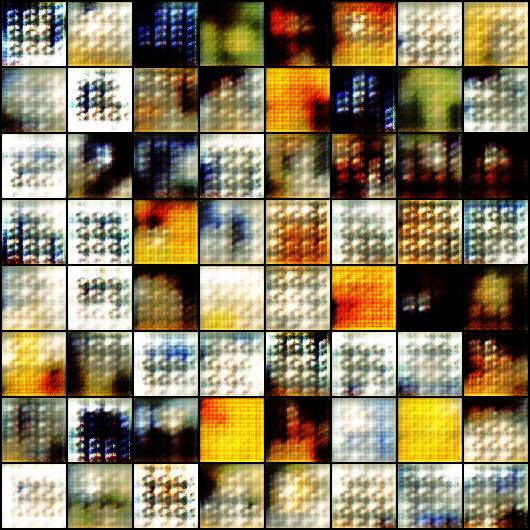

In [40]:
Image('./generated/generated-images-0013.png')

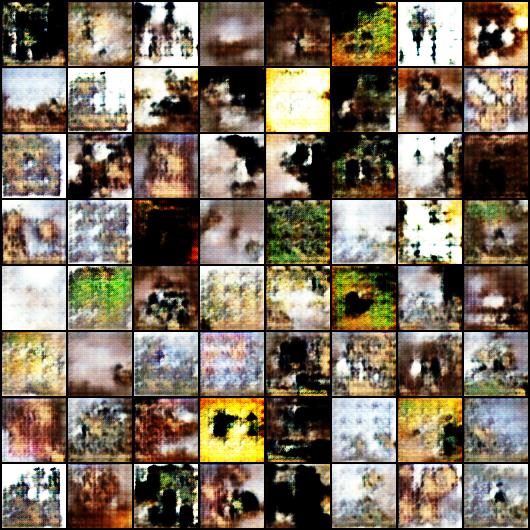

In [41]:
Image('./generated/generated-images-0037.png')

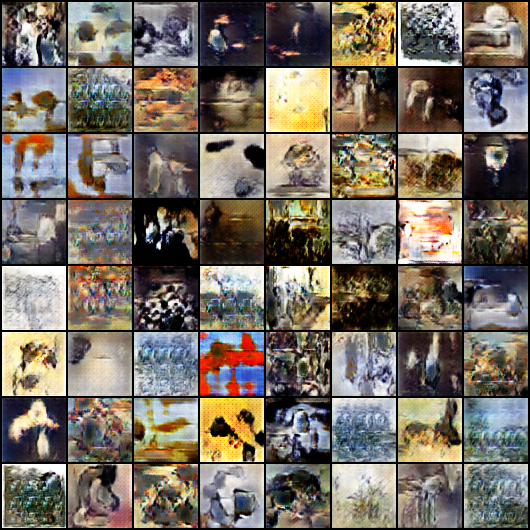

In [42]:
Image('./generated/generated-images-0072.png')

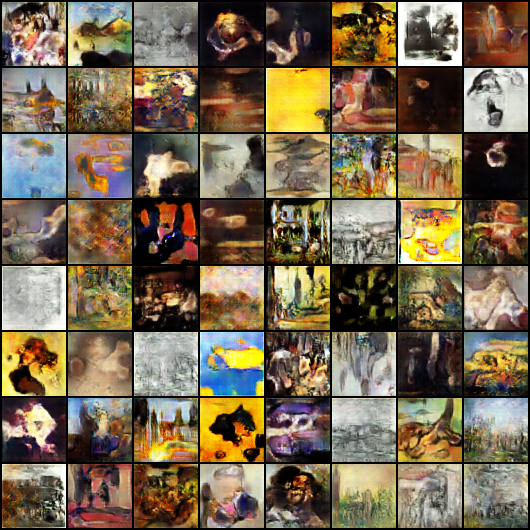

In [43]:
Image('./generated/generated-images-0103.png')

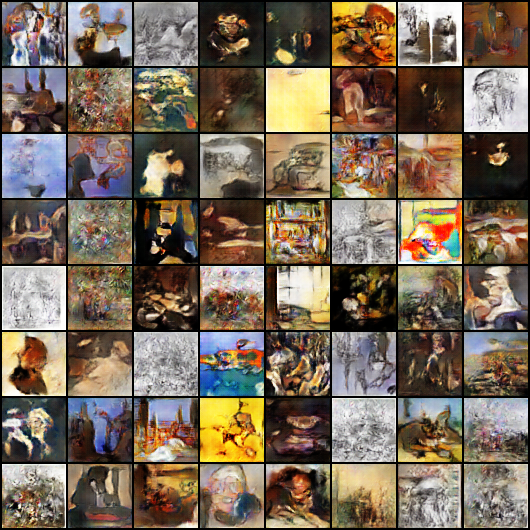

In [44]:
Image('./generated/generated-images-0138.png')

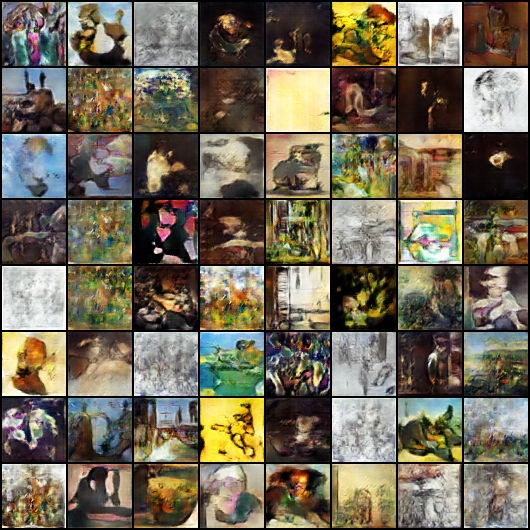

In [45]:
Image('./generated/generated-images-0147.png')

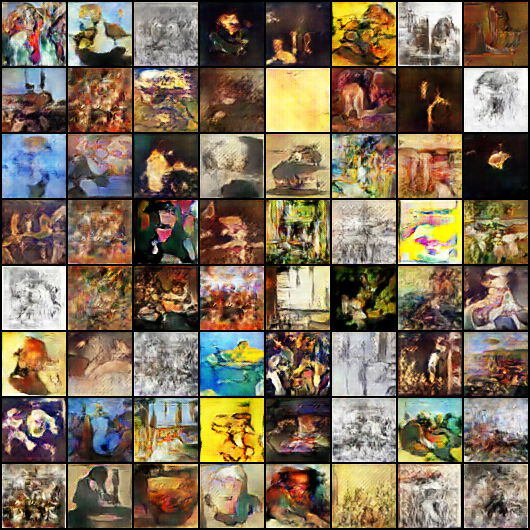

In [46]:
Image('./generated/generated-images-0150.png')

In [47]:
losses_g, losses_d, real_scores, fake_scores = history

In [48]:
#jovian.log_metrics(loss_g=losses_g[-1], 
#                   loss_d=losses_d[-1], 
#                   real_score=real_scores[-1], 
#                   fake_score=fake_scores[-1])

NameError: name 'jovian' is not defined

In [49]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

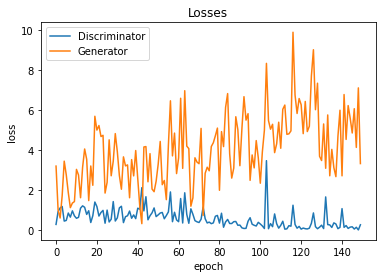

In [50]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

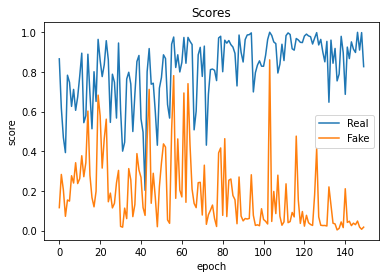

In [51]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [98]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()